In [59]:
import numpy as np
import matplotlib.pyplot as plt
import math
# MADE ACCORDING TO THIS:
#http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/#mathybits
#https://habr.com/ru/post/166693/

In [60]:
def groundTruthStates(x0, v0, a, deltaT, N, sigma):
    #states contain info about position and velocity. 0 - position, 1 - velocity.
    states = np.empty((N, 2), dtype=float)
    
    states[0, 1] = v0
    states[0, 0] = x0
    
    for i in range(1, N):
        perturbation = np.random.rand(1) * sigma
        
        
        #straight forward formulas
        #Changing part (deltaT ** 2) or np.square(deltaT) or deltaT * deltaT produce slightly different results
        
        states[i, 0] = states[i - 1, 0] + (states[i - 1, 1] * deltaT) + (0.5 * a * (np.square(deltaT))) + perturbation
        states[i, 1] = states[i - 1, 1] + (a * deltaT)
        
 
    
    return states

# Test the function

# Boat traveling with 5 m/s
testSpeed = 5

# Boat accelerating with 2 m/s^2
testAcc = 2

# Time between calculations is 1 sec
deltaT = 1

# Number of positions should be 10
N = 10

states = groundTruthStates(0, testSpeed, testAcc, deltaT, N, 2)

# When no acceleration, the boat should travel 5 m each time step
statesWithoutAcc = groundTruthStates(0, testSpeed, 0, deltaT, N, 2)

print(states)
print(statesWithoutAcc)


[[  0.           5.        ]
 [  6.13710152   7.        ]
 [ 15.27558594   9.        ]
 [ 26.12464823  11.        ]
 [ 38.69892955  13.        ]
 [ 53.90402006  15.        ]
 [ 69.98868304  17.        ]
 [ 88.84807959  19.        ]
 [110.37209357  21.        ]
 [132.70969397  23.        ]]
[[ 0.          5.        ]
 [ 6.89340509  5.        ]
 [12.40254891  5.        ]
 [18.39284823  5.        ]
 [23.84405892  5.        ]
 [29.63351249  5.        ]
 [34.76421282  5.        ]
 [41.31242814  5.        ]
 [48.19928837  5.        ]
 [54.91861409  5.        ]]


In [61]:
def makeNoisedStates(states, sigmaPos, sigmaVelo):
    noisedStates = np.empty((len(states), 2), dtype=float)
    #We are creating the matrix of the same size to fill it in with noised values
    noisedStates[0, 0] = states[0, 0]
    #initial state is the same, no noise.
    
    #velocityPerturbations = np.random.rand(1) * sigmaVelo
    #positionPerturbations = np.random.rand(1) * sigmaPos
    
    for i in range(1, len(noisedStates)):
        velocityPerturbations = np.random.rand(1) * sigmaVelo
        positionPerturbations = np.random.rand(1) * sigmaPos
        
        noisedStates[i, 0] = states[i, 0] + positionPerturbations
        noisedStates[i, 1] = states[i, 1] + velocityPerturbations
    
    return noisedStates
        
    
print(makeNoisedStates(states, 2, 2))    

[[  0.           5.        ]
 [  6.74263699   7.7616039 ]
 [ 15.40291243  10.40025332]
 [ 26.79891323  11.42814352]
 [ 39.53351643  14.16551759]
 [ 55.04739544  16.01210805]
 [ 71.27384509  17.56028819]
 [ 90.80362154  20.53131171]
 [110.60081796  21.46718837]
 [132.88983894  24.57864996]]


In [62]:
def kalmanPrediction(measuredStates, sigmaPositions, sigmaSpeed, sigmaPerturbations, a):
    """ Applies the Kalman filter to the given measured positions and returns
    it's best guess, where the boat most probably could be.
    
    Parameters
    ----------
    measuredStates: 2 dimensional array of floats
        The measured states of the boat.
        
    sigmaPosition: float
        Standard deviation of the normal distribution (Xi).
        
    sigmaSpeed: float
        Standard deviation of the normal distribution (Eta).
        
    sigmaPerturbations: float
        Standard deviation of the normal distribution (Zeta).
        
    a: float
        Acceleration of the boat.
        
    Returns
    -------
    2 dimensional array
        An array of state estimates that are caculated using the Kalman Filter. "The best guess".
    """ 
    
    #Variance = square(sigma)
    #1 Variances
    varianceSpeed = sigmaSpeed ** 2
    variancePositions = sigmaPositions ** 2
    covariance = math.sqrt(varianceSpeed * variancePositions)
    
    
    
    #2 creating matrix for predicted states. 
    #It depends on which states we got into out function
    predictedStates = np.empty((len(measuredStates), 2), dtype=float)
    
    #initial values for predictedStates are the same as for states, given to function
    predictedStates[0] = measuredStates[0]
    
    #Creating covariation matrices. Update them later on each step
    covarianceMatrices = np.empty((len(measuredStates), 2, 2), dtype=float)
    
    #covariance Matrix
    P = np.array([[1, 0],
                  [0, 1]])
    
    #initializing covarianceMatrices with first matrix
    covarianceMatrices[0] = P
    
    

    #3 Creating other matrices, needed for calculations
    #F - prediction matrix
    F = np.array([[1, deltaT],
                  [0, 1]])
    
    #B - control matrix - external influence
    B = np.array([(deltaT ** 2) / 2, deltaT])
    
    #u - control vector, also external influence
    u = np.array([a, a])
    
    #R - matrix with covariance of measurement and noise / covariance of this uncertainty
    R = np.array([[covariance, 0], 
                  [0, covariance]])
    
    #Q - random fluctuations to a system, e.g. blowing wind
    Q = np.array([[0, 0],
                  [0, 0]])
    
    #H - identity matrix
    H = np.array([[1, 0],
                  [0, 1]])
    
    #Pk = Fk * Pk-1 * transposed(Fk) + Qk
    
    #4 Kalman Gain | K = Hk * Pk * transposed(Hk) * inversed(Hk*Pk*(transposed(Hk)) + Rk)
    for i in range(1, len(measuredStates)):
        
        predictedState = F.dot(predictedStates[i - 1]) + B.dot(u)
        
        #next step in covariance matrix
        P = (F.dot(covarianceMatrices[i -1])).dot(np.transpose(F)) + Q
        
        #Kalman gain
        kalmanGain = (P.dot(np.transpose(H))).dot(np.linalg.inv((H.dot(P)).dot(np.transpose(H)) + R))
        
        # correct the predicted state using the measurements
        correctedState = predictedState + kalmanGain.dot(measuredStates[i] - (H.dot(predictedState)))
        
        # update the state error covariance matrix
        updatedP = P - ((kalmanGain.dot(H)).dot(P))
        covarianceMatrices[i] = updatedP
        
        # save the best estimate
        predictedStates[i] = correctedState
        
    return predictedStates

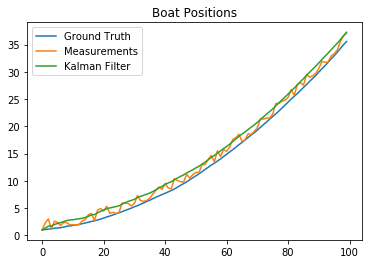

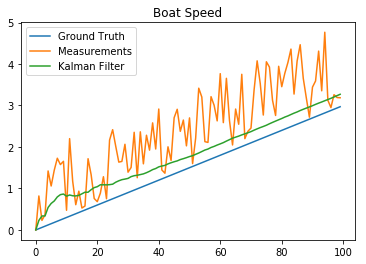

In [63]:
# Boat starting at position 1m
x0 = 1

# Boat traveling with 0 m/s at the beginning
v0 = 0

# Boat accelerating with 0.15 m/s^2
a = 0.15

# Time between calculations is 0.2 sec
deltaT = 0.2

# Number of positions should be 100
N = 100

# SD for Xi is 2 (square root of variance 4)
standardDeviationXi = 2

# SD for Eta is 2 (square root of variance 4)
standardDeviationEta = 2

# SD for Zeta is 0.1 (square root of variance 0.01)
standardDeviationZeta = 0.1

groundTruth = groundTruthStates(x0, v0, a, deltaT, N, standardDeviationZeta)
measurements = makeNoisedStates(groundTruth, standardDeviationXi, standardDeviationEta)

predictions = kalmanPrediction(measurements, standardDeviationXi, standardDeviationEta, standardDeviationZeta, a)


# Plot the ground truth, measurements and ..
plt.figure(1)
plt.title('Boat Positions')
plt.plot(groundTruth[:,0], label="Ground Truth")
plt.plot(measurements[:,0], label="Measurements")
plt.plot(predictions[:,0], label="Kalman Filter")
plt.legend(loc='upper left')
plt.show()

# Speed
plt.figure(1)
plt.title('Boat Speed')
plt.plot(groundTruth[:,1], label="Ground Truth")
plt.plot(measurements[:,1], label="Measurements")
plt.plot(predictions[:,1], label="Kalman Filter")
plt.legend(loc='upper left')
plt.show()